# *(Yang, 2020)*: Dynamical system analysis for RNN

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/examples/blob/main/recurrent_networks/Yang_2020_RNN_Analysis.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/examples/blob/main/recurrent_networks/Yang_2020_RNN_Analysis.ipynb)

Implementation of the paper:

- Yang G R, Wang X J. Artificial neural networks for neuroscientists: A primer[J]. Neuron, 2020, 107(6): 1048-1070.

The original implementation is based on PyTorch: https://github.com/gyyang/nn-brain/blob/master/RNN%2BDynamicalSystemAnalysis.ipynb

In [161]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd

bp.math.set_platform('cpu')

In [162]:
bp.__version__

'2.4.3'

In [163]:
bd.__version__

'0.0.0.6'

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In this tutorial, we will use supervised learning to train a recurrent neural network on a simple perceptual decision making task, and analyze the trained network using dynamical system analysis.

## Defining a cognitive task

In [165]:
dataset = bd.cognitive.RatePerceptualDecisionMaking()
task = bd.cognitive.TaskLoader(dataset, batch_size=16)

## Define a vanilla continuous-time recurrent network

Here we will define a continuous-time neural network but discretize it in time using the Euler method.

\begin{align}
    \tau \frac{d\mathbf{r}}{dt} = -\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r).
\end{align}

This continuous-time system can then be discretized using the Euler method with a time step of $\Delta t$, 

\begin{align}
    \mathbf{r}(t+\Delta t) = \mathbf{r}(t) + \Delta \mathbf{r} = \mathbf{r}(t) + \frac{\Delta t}{\tau}[-\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)].
\end{align}

In [166]:
class RNN(bp.DynamicalSystem):
  def __init__(self, 
               num_input, 
               num_hidden, 
               num_output, 
               num_batch, 
               dt=None, seed=None,
               w_ir=bp.init.KaimingNormal(scale=1.),
               w_rr=bp.init.KaimingNormal(scale=1.),
               w_ro=bp.init.KaimingNormal(scale=1.)):
    super(RNN, self).__init__()

    # parameters
    self.tau = 100
    self.num_batch = num_batch
    self.num_input = num_input
    self.num_hidden = num_hidden
    self.num_output = num_output
    if dt is None:
      self.alpha = 1
    else:
      self.alpha = dt / self.tau
    self.rng = bm.random.RandomState(seed=seed)

    # input weight
    self.w_ir = bm.TrainVar(bp.init.parameter(w_ir, (num_input, num_hidden)))

    # recurrent weight
    bound = 1 / num_hidden ** 0.5
    self.w_rr = bm.TrainVar(bp.init.parameter(w_rr, (num_hidden, num_hidden)))
    self.b_rr = bm.TrainVar(self.rng.uniform(-bound, bound, num_hidden))

    # readout weight
    self.w_ro = bm.TrainVar(bp.init.parameter(w_ro, (num_hidden, num_output)))
    self.b_ro = bm.TrainVar(self.rng.uniform(-bound, bound, num_output))

    self.reset_state(self.mode)

  def reset_state(self, batch_size):
    self.h = bp.init.variable_(bm.zeros, self.num_hidden, batch_size)
    self.o = bp.init.variable_(bm.zeros, self.num_output, batch_size)

  def cell(self, x, h):
    ins = x @ self.w_ir + h @ self.w_rr + self.b_rr
    state = h * (1 - self.alpha) + ins * self.alpha
    return bm.relu(state)

  def readout(self, h):
    return h @ self.w_ro + self.b_ro

  def update(self, x):
    self.h.value = self.cell(x, self.h)
    self.o.value = self.readout(self.h)
    return self.h.value, self.o.value

  def predict(self, xs):
    self.h[:] = 0.
    return bm.for_loop(self.update, xs)

  def loss(self, xs, ys):
    hs, os = self.predict(xs)
    os = os.reshape((-1, os.shape[-1]))
    loss = bp.losses.cross_entropy_loss(os, ys.flatten())
    return loss, os

## Train the recurrent network on the decision-making task

In [167]:
# Instantiate the network and print information
hidden_size = 64
with bm.environment(mode=bm.TrainingMode(batch_size=16)):
    net = RNN(num_input=dataset.num_inputs,
              num_hidden=hidden_size,
              num_output=dataset.num_outputs,
              num_batch=task.batch_size,
              dt=dataset.dt)

In [168]:
# Adam optimizer
opt = bp.optim.Adam(lr=0.001, train_vars=net.train_vars().unique())

# gradient function
grad_f = bm.grad(net.loss,
                 grad_vars=net.train_vars().unique(),
                 return_value=True,
                 has_aux=True)

# training function
@bm.jit
def train(xs, ys):
  grads, l, os = grad_f(xs, ys)
  opt.update(grads)
  return l, os

In [169]:
running_acc = []
running_loss = []
for i_batch in range(20):
    for X, Y in task:
        # training
        loss, outputs = train(bm.asarray(X), bm.asarray(Y))
        # Compute performance
        output_np = np.asarray(bm.argmax(outputs, axis=-1)).flatten()
        labels_np = np.asarray(Y).flatten()
        ind = labels_np > 0 # 0: fixation, 1: choice 1, 2: choice 2
        running_loss.append(loss)
        running_acc.append(np.mean(labels_np[ind] == output_np[ind]))
    print(f'Batch {i_batch + 1}, Loss {np.mean(running_loss):0.4f}, Acc {np.mean(running_acc):0.3f}')
    running_loss = []
    running_acc = []

Batch 1, Loss 0.2494, Acc 0.164
Batch 2, Loss 0.0526, Acc 0.663
Batch 3, Loss 0.0375, Acc 0.766
Batch 4, Loss 0.0314, Acc 0.775
Batch 5, Loss 0.0294, Acc 0.780
Batch 6, Loss 0.0291, Acc 0.796
Batch 7, Loss 0.0249, Acc 0.830
Batch 8, Loss 0.0251, Acc 0.812
Batch 9, Loss 0.0223, Acc 0.827
Batch 10, Loss 0.0209, Acc 0.848
Batch 11, Loss 0.0218, Acc 0.817
Batch 12, Loss 0.0220, Acc 0.822
Batch 13, Loss 0.0191, Acc 0.853
Batch 14, Loss 0.0176, Acc 0.861
Batch 15, Loss 0.0216, Acc 0.832
Batch 16, Loss 0.0177, Acc 0.882
Batch 17, Loss 0.0180, Acc 0.864
Batch 18, Loss 0.0166, Acc 0.869
Batch 19, Loss 0.0162, Acc 0.861
Batch 20, Loss 0.0160, Acc 0.871


## Visualize neural activity for in sample trials

We will run the network for 100 sample trials, then visual the neural activity trajectories in a PCA space.

In [170]:
num_trial = 100
task = bd.cognitive.TaskLoader(dataset, batch_size=num_trial)
inputs, trial_infos = task.get_batch()

# reset the network state to match the required batch size
net.reset_state(num_trial)

# get the RNN activity
rnn_activity, _ = net.predict(inputs)
rnn_activity = np.asarray(rnn_activity)
trial_infos = np.asarray(trial_infos)

# Concatenate activity for PCA
activity = rnn_activity.reshape(-1, hidden_size)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

Shape of the neural activity: (Time points, Neurons):  (2200, 64)


In [171]:
pca = PCA(n_components=2)
pca.fit(activity)

PCA(n_components=2)

Transform individual trials and Visualize in PC space based on ground-truth color. We see that the neural activity is organized by stimulus ground-truth in PC1

In [172]:
trial_infos.shape, inputs.shape


((22, 100), (22, 100, 3))

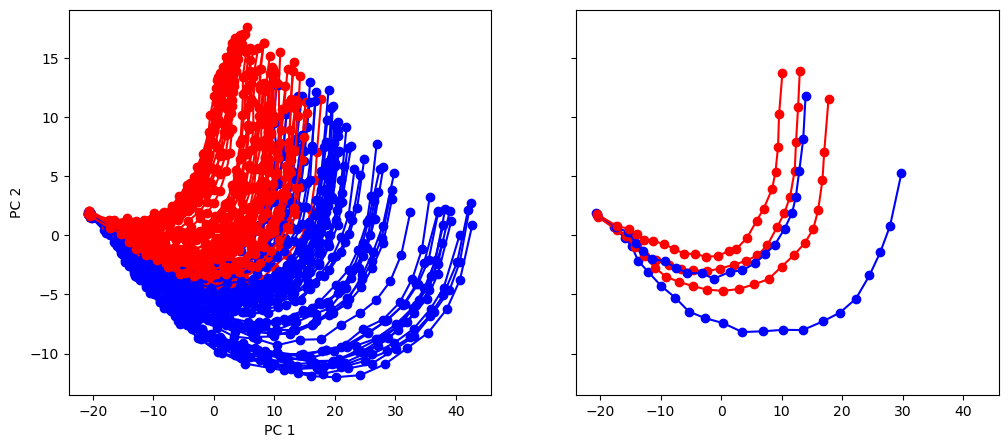

In [173]:
plt.rcdefaults()
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 5))
for i in range(num_trial):
    activity_pc = pca.transform(rnn_activity[:, i])
    color = 'red' if trial_infos[-1, i] == 1 else 'blue'
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    if i < 5:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
plt.show()

## Search for approximate fixed points

Here we search for approximate fixed points and visualize them in the same PC space. In a generic dynamical system,
\begin{align}
    \frac{d\mathbf{x}}{dt} = F(\mathbf{x}),
\end{align}
We can search for fixed points by doing the optimization
\begin{align}
    \mathrm{argmin}_{\mathbf{x}} |F(\mathbf{x})|^2.
\end{align}

In [174]:
f_cell = lambda h: net.cell(bm.asarray([1, 0.5, 0.5]), h)

In [175]:
fp_candidates = bm.asarray(activity)

In [176]:
fp_candidates.shape

(2200, 64)

In [177]:
finder = bp.analysis.SlowPointFinder(f_cell=f_cell, f_type='discrete')
finder.find_fps_with_gd_method(
    candidates=fp_candidates,
    tolerance=1e-4,
    num_batch=200,
    optimizer=bp.optim.Adam(lr=1e-3),
)
finder.filter_loss(tolerance=1e-4)
finder.keep_unique(tolerance=0.03)
finder.exclude_outliers(0.1)
fixed_points = finder.fixed_points

Optimizing with Adam(lr=Constant(lr=0.001, last_epoch=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-200 in 0.16 sec, Training loss 0.0802390501
    Batches 201-400 in 0.14 sec, Training loss 0.0552543662
    Batches 401-600 in 0.14 sec, Training loss 0.0439432897
    Batches 601-800 in 0.15 sec, Training loss 0.0374152139
    Batches 801-1000 in 0.14 sec, Training loss 0.0330325253
    Batches 1001-1200 in 0.14 sec, Training loss 0.0297763441
    Batches 1201-1400 in 0.14 sec, Training loss 0.0271856301
    Batches 1401-1600 in 0.13 sec, Training loss 0.0250399429
    Batches 1601-1800 in 0.14 sec, Training loss 0.0232114382
    Batches 1801-2000 in 0.14 sec, Training loss 0.0216213744
    Batches 2001-2200 in 0.15 sec, Training loss 0.0202192534
    Batches 2201-2400 in 0.13 sec, Training loss 0.0189735591
    Batches 2401-2600 in 0.13 sec, Training loss 0.0178660452
    Batches 2601-2800 in 0.14 sec, Training loss 0.0168767571
    Batches 2801-3000 in 0.

## Visualize the found approximate fixed points.

We see that they found an approximate line attrator, corresponding to our PC1, along which evidence is integrated during the stimulus period.

In [178]:
fixed_points.shape

(66, 64)

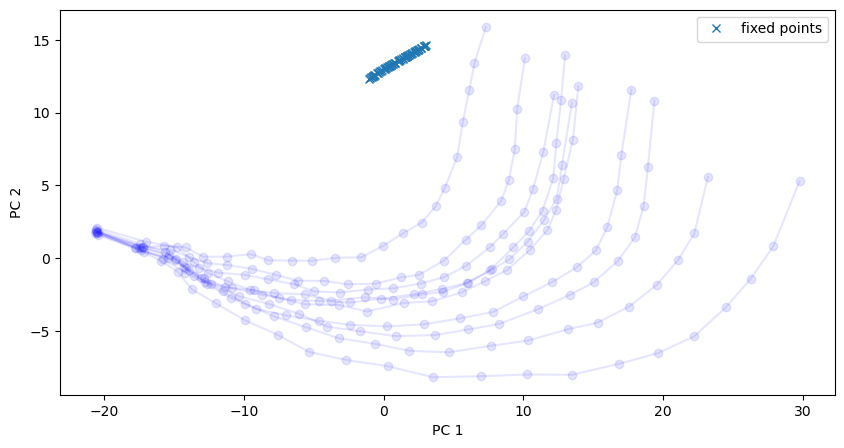

In [179]:
# Plot in the same space as activity
plt.figure(figsize=(10, 5))
for i in range(10):
    activity_pc = pca.transform(rnn_activity[:, i])
    color = 'red' if trial_infos[-1, i] == 0 else 'blue'
    plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color, alpha=0.1)

# Fixed points are shown in cross
fixedpoints_pc = pca.transform(fixed_points)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', label='fixed points')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()

## Computing the Jacobian and finding the line attractor

In [180]:
from jax import jacobian

In [181]:
dFdh = jacobian(f_cell)(fixed_points[2])

eigval, eigvec = np.linalg.eig(bm.as_numpy(dFdh))

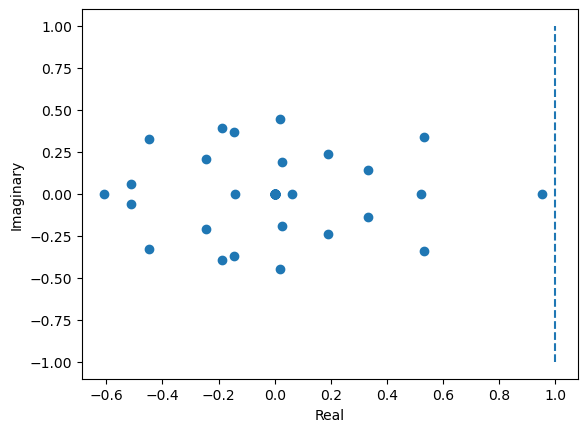

In [182]:
# Plot distribution of eigenvalues in a 2-d real-imaginary plot
plt.figure()
plt.scatter(np.real(eigval), np.imag(eigval))
plt.plot([1, 1], [-1, 1], '--')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()